In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, precision_score,recall_score, mean_squared_error
from sklearn.metrics import  confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBRegressor
import statsmodels.api as sm
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import sklearn.metrics as metrics
import matplotlib.patches as  mpatches
import timeit
from sklearn.metrics import roc_auc_score


Load data

In [2]:
df = pd.read_csv("/kaggle/input/lendingclub/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv", parse_dates=['issue_d'], infer_datetime_format=True)
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df.head())
df = df[(df.issue_d >= '2018-01-01 00:00:00') ]
df = df.sample(n=200000)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,N

Plotting the interest rate values

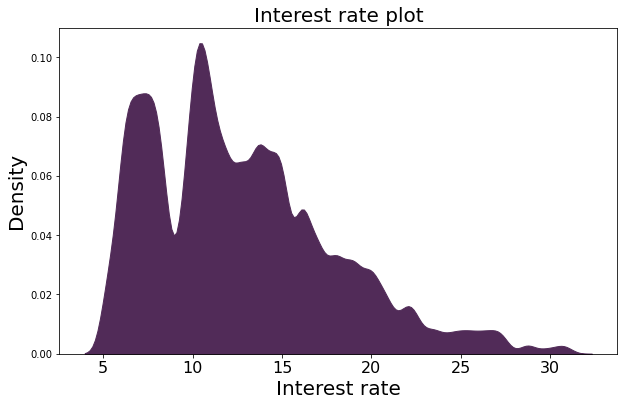

In [3]:
import matplotlib.patches as  mpatches

plt.figure(figsize = (10,6))
ax = sns.kdeplot(data = df, x = 'int_rate', shade = True, alpha = 1, color = '#512b58' )


plt.xticks(fontsize=16)
ax.set_xlabel("Interest rate", fontsize = 20)
ax.set_ylabel("Density", fontsize = 20)
ax.set_title("Interest rate plot", fontsize = 20)

plt.show()

From the graph we see that interest rate values are mostly from 5 to 30.

# Prediction model for Interest rate

Define column names I will be using in prediction model.

In [4]:
numerical_features = [
    'acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc',
       'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'dti_joint', 'fico_range_high', 'fico_range_low', 'funded_amnt',
       'funded_amnt_inv', 'hardship_amount', 'hardship_dpd',
       'hardship_last_payment_amount', 'hardship_payoff_balance_amount',
       'il_util', 'inq_fi', 'inq_last_12m', 'inq_last_6mths',
       'installment', 'last_fico_range_high',
       'last_fico_range_low', 'last_pymnt_amnt', 'loan_amnt',
       'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_last_major_derog',
       'mths_since_last_record', 'mths_since_rcnt_il',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'open_rv_12m', 'open_rv_24m',
       'orig_projected_additional_accrued_interest', 'out_prncp',
       'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec',
       'pub_rec_bankruptcies', 'recoveries', 'revol_bal',
       'revol_bal_joint', 'revol_util',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med', 'sec_app_fico_range_high',
       'sec_app_fico_range_low', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog',
       'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il',
       'sec_app_revol_util', 'settlement_amount', 'settlement_percentage',
       'settlement_term', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal',
       'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort',
       'total_bal_il', 'total_bc_limit', 'total_cu_tl',
       'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
       'total_rev_hi_lim'
]
categorical_features = [
       'term', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan',
       'purpose', 'title',
       'initial_list_status', 'last_pymnt_d',
       'verification_status_joint',
       'hardship_flag', 'hardship_reason',
       'hardship_status', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_loan_status',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'
]
label_column = 'int_rate'

In [5]:
df = df.dropna(subset = ['int_rate'])

Split dataset

In [6]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=1)

# Base line

Creating a dummy model which predict the most frequent category

In [7]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(train_data[numerical_features + categorical_features], train_data[label_column])
dummy_pred = dummy_regr.predict(test_data[numerical_features + categorical_features])

In [8]:
y_test = test_data[label_column].to_numpy()

In [9]:
def print_results( y_pred, y_test):
    print('Mean squared error: ' + str(mean_squared_error(y_test, y_pred)))
    

In [10]:
print_results(dummy_pred, y_test)


Mean squared error: 26.39450256537652


# Interest rate regression model

Define pipeline

In [11]:
categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="constant")),
        (
            "categorical_encoder",
            OneHotEncoder(handle_unknown='ignore'),
        ),
    ]
)

numerical_transformer = Pipeline(
    steps=[
        ("numerical_imputer", SimpleImputer(strategy="constant", fill_value = -999999)),
        (
            "numerical_scaler",
            StandardScaler(),
        ),
    ]
)

preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_transformer,
            categorical_features,
        ),
        (
            "numerical",
            numerical_transformer,
            numerical_features,
        ),
    ]
)

I will be using XGBoost Regressor

In [12]:
model = XGBRegressor()

In [13]:
pipe = Pipeline([("preprocessor", preprocessor),
                        ("model", model)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'loan_status', 'pymnt_plan',
                                                   'purpose', 'title',
                                                   'initial_list_status',
                                                   'las...
        

In [14]:
%%time
pipe.fit(
    train_data[numerical_features + categorical_features], train_data[label_column]
)

CPU times: user 7min 24s, sys: 1.26 s, total: 7min 26s
Wall time: 1min 57s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'loan_status', 'pymnt_plan',
                                                   'purpose', 'title',
                                                   'initial_list_status',
                                                   'las...
        

Calculate prediction scores

In [15]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])
print_results(y_pred, y_test)

Mean squared error: 1.381622071101455


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


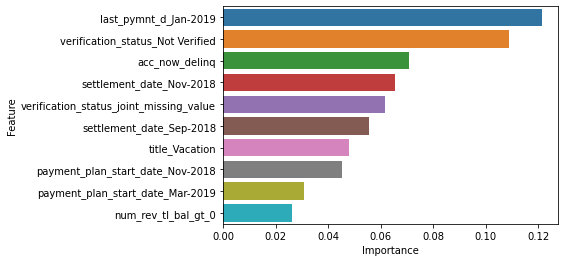

In [16]:
names_num = test_data[numerical_features].columns.values
names_cat = pipe.named_steps['preprocessor'].named_transformers_['categorical'].named_steps["categorical_encoder"].get_feature_names(categorical_features)
names = np.concatenate([names_num, names_cat])
imp = pipe.steps[1][1].feature_importances_
data = pd.DataFrame({'Feature': names, 'Importance': imp})
data = data.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=data);

## Smaller model

Making smaller model with top 10 features

In [17]:
numerical_features = [
    'dti_joint',
    'fico_range_high', 
    'fico_range_low',
    'funded_amnt',
    'funded_amnt_inv',
    'acc_now_delinq'
]
categorical_features = [    
    'home_ownership',
    'last_pymnt_d',
    'settlement_date'
]
label_column = 'int_rate'

In [18]:
preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_transformer,
            categorical_features,
        ),
        (
            "numerical",
            numerical_transformer,
            numerical_features,
        ),
    ]
)

In [19]:
pipe = Pipeline([("preprocessor", preprocessor),
                        ("model", model)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['home_ownership',
                                                   'last_pymnt_d',
                                                   'settlement_date']),
                                                 ('numerical',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer(fill_value=-99...
                              gamma=0, gpu_id=-1, 

In [20]:
%%time
pipe.fit(
    train_data[numerical_features + categorical_features], train_data[label_column]
)

CPU times: user 30.7 s, sys: 47.7 ms, total: 30.8 s
Wall time: 8.02 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['home_ownership',
                                                   'last_pymnt_d',
                                                   'settlement_date']),
                                                 ('numerical',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer(fill_value=-99...
                              gamma=0, gpu_id=-1, 

In [21]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])
print_results(y_pred, y_test)

Mean squared error: 19.18541036379132


In [22]:
import joblib

filename = 'intRateModel.joblib'
joblib.dump(pipe, filename)

['intRateModel.joblib']

In [23]:
test_data[numerical_features + categorical_features].head(10)

,dti_joint,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,acc_now_delinq,home_ownership,last_pymnt_d,settlement_date
837662,NaN,664.0,660.0,4000.0,4000.0,0.0,RENT,Feb-2019,NaN
834782,NaN,704.0,700.0,13000.0,13000.0,0.0,MORTGAGE,Aug-2018,NaN
799663,NaN,679.0,675.0,15000.0,15000.0,0.0,RENT,Mar-2019,NaN
1414658,NaN,784.0,780.0,8000.0,8000.0,0.0,RENT,Mar-2019,NaN
1578423,37.57,779.0,775.0,20000.0,20000.0,0.0,MORTGAGE,Mar-2019,NaN
450423,20.64,804.0,800.0,40000.0,40000.0,0.0,OWN,Mar-2019,NaN
847340,NaN,754.0,750.0,23200.0,23200.0,0.0,RENT,Mar-2019,NaN
1419000,NaN,729.0,725.0,7000.0,7000.0,0.0,RENT,Mar-2019,NaN
791784,29.68,684.0,680.0,20000.0,20000.0,0.0,MORTGAGE,Feb-2019,NaN
1466748,10.76,754.0,750.0,30000.0,30000.0,0.0,MORTGAGE,Mar-2019,NaN
